In [1]:
import numpy as np
import scipy as sp
from scipy import integrate
import matplotlib.pyplot as plt
from sklearn import linear_model

# Set up functions to compute sparese regression and DMD

Define a wrapper for scikit learn's lasso function and add other useful functions for sparse regression and DMD

In [2]:
def lasso(A,b,alpha=1):
    '''
    Parameters
    ----------
    A: array like 
    b: array like (must be compatiable with A)
    alpha: float
    Returns
    -------
    array solving minimization problem: min_x: ||b-Ax||_2 + alpha*||x||_1
    '''
    reg = linear_model.Lasso(alpha=alpha/len(A))
    reg.fit(A,b)
    return reg.coef_

In [3]:
def get_poly_exponents(l, n, start=0):
    '''
    Parameters
    ----------
    l: integer
    n: integer
    start: integer

    Returns
    -------
    generator of all tuples of length l whose minimum entry is start and whose entries sum to at most n
    '''
    if l == 0:
        yield ()
    else:
        for x in range(start, n+1):
            for t in get_poly_exponents(l - 1, n):
                if sum(t) + x <= n:
                    yield t + (x,)

In [4]:
def binomial_expand(x,d):
    '''
    Parameters
    ----------
    x: array like 
    max_deg: integer

    Returns
    -------
    ndarray whose entries are 1, x_0, x_1, ..., x_k, x_0^2, x_0x_1, ..., x_0x_k, x_1^2, x_1x_2, ...
    '''
    E_ = np.array(list(get_poly_exponents(len(x),d)))
    E = E_[np.argsort(np.sum(E_,axis=1))]
    return np.array([np.prod([x[k]**e[k] for k in range(len(x))],axis=0) for e in E ]).T

def print_binomial_expand(x,d):
    E_ = np.array(list(get_poly_exponents(len(x),d)))
    E = E_[np.argsort(np.sum(E_,axis=1))]
    for j,e in enumerate(E):
        print('coefficient:',j,'--> exponents:',e)

In [5]:
def time_delay_embed(x,J):
    '''
    Compute time delay embedding matrix of x
    '''
    return np.reshape([x[:,j:-J+j] for j in range(J)],(-1,np.shape(x)[1]-J))

In [6]:
def get_dmd_modes(X1,X2,r):
    '''
    Compute approximate eigenvetors and values to A solving min |X2-AX1|_F
    '''
    u,s,vt = np.linalg.svd(X1,full_matrices=False)

    u_hat = u[:,:r]
    s_hat = s[:r]
    v_hat = vt[:r].conjugate().T

    S = u_hat.conjugate().T@X2@v_hat@np.diag(1/s_hat)
    
    Lambda,W = np.linalg.eig(S)
    
    Phi = X2@v_hat@np.diag(1/s_hat)@W#@np.diag(Lambda)
    
    return Lambda, Phi
    
def get_mode_time_evolution(Lambda, Phi, x0, t):
    '''
    Compute weighting of DMD in time
    '''
    dt = t[1]-t[0]
    
    omega = np.log(Lambda)/dt
    b = np.linalg.lstsq(Phi,x0)[0]
    
    def u_modes(t): 
        return np.exp(omega*t)*b
    
    return np.array([u_modes(tj) for tj in t]).T

# Import Data

In [7]:
data_test = np.loadtxt("data_test.txt")
data_withold = np.loadtxt("data_withold.txt")

In [12]:
t = data_test[:,0]
x = data_test[:,1:].T

dt = t[1]-t[0]

t_withold = data_withold[:,0]
x_withold = data_withold[:,1:].T

# Plot Data

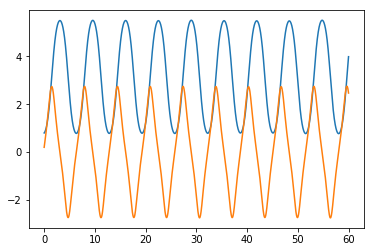

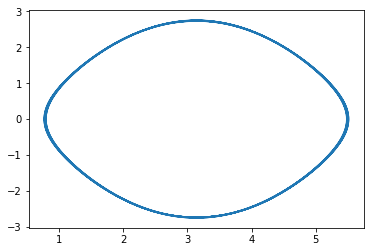

In [77]:
plt.figure()
plt.plot(t,x[0])
plt.plot(t,x[1])
plt.show()

plt.figure()
plt.plot(x[0],x[1])
plt.show()

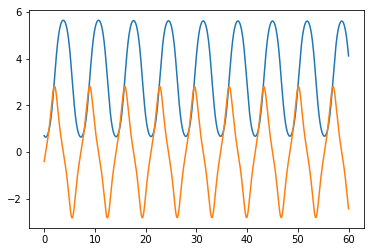

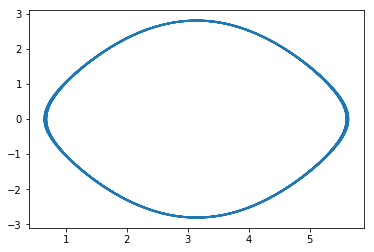

In [145]:
plt.figure()
plt.plot(t_withold,x_withold[0])
plt.plot(t_withold,x_withold[1])
plt.show()

plt.figure()
plt.plot(x_withold[0],x_withold[1])
plt.show()

# 1. Use sparse regression techniques to identify the nonlinear dynamical system that produced the data.

Note here that we are trying a library of polynomials in the two variables $x_1$ and $x_2$ due to time constraints. In practice, it would be easy to extend this library to contain other more functions. I feel that tuning the library is a bit out of the scope of this exam, so I will just leave it as the polynomials as a "proof of concept"

coefficient: 0 --> exponents: [0 0]
coefficient: 1 --> exponents: [1 0]
coefficient: 2 --> exponents: [0 1]
coefficient: 3 --> exponents: [2 0]
coefficient: 4 --> exponents: [1 1]
coefficient: 5 --> exponents: [0 2]
coefficient: 6 --> exponents: [3 0]
coefficient: 7 --> exponents: [2 1]
coefficient: 8 --> exponents: [1 2]
coefficient: 9 --> exponents: [0 3]


/home/tyler/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


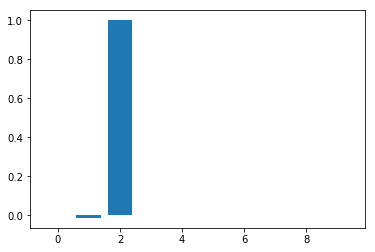

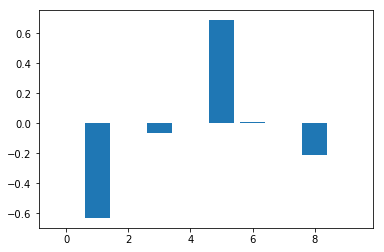

In [91]:
# take mesh points up to t=40
N = len(t)
x0 = x[0]
x1 = x[1]

# print order of terms in library
print_binomial_expand([x0,x1],3)

# generate library
lib = binomial_expand([x0,x1],3)

# compute time derivative of x
x_t = (x[:,2:N]-x[:,:N-2])/(2*dt)

# do sparse regression
c = lasso(lib[1:-1],x_t.T,1)


# plot coefficeints
plt.figure()
plt.bar(np.arange(len(c.T)),c[0])
plt.show()

plt.figure()
plt.bar(np.arange(len(c.T)),c[1])
plt.show()

In [92]:
d = c

### Remove columns of library with small coefficients and re-regress

Again this is just a proof of concept. Since we are looking for a sparse fit to the library, we can manually remove some elements from the library if they are deemed to be insignificant. Again, this requires runing in practice, and so we just do it lazily here.

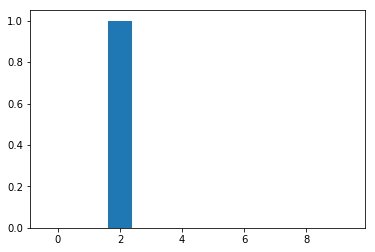

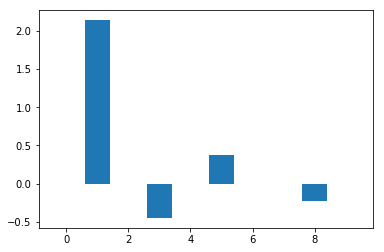

In [95]:
tol = .01

d = np.zeros(np.shape(c))

d[0,:] = np.linalg.lstsq(lib[1:-1]@np.diag(np.abs(c[0])>tol),x_t[0].T)[0]
d[1,:] = np.linalg.lstsq(lib[1:-1]@np.diag(np.abs(c[1])>tol),x_t[1].T)[0]

# plot coefficeints
plt.figure()
plt.bar(np.arange(len(d.T)),d[0])
plt.show()

plt.figure()
plt.bar(np.arange(len(d.T)),d[1])
plt.show()

# 2. With your discovered dynamical system, evaluate its ability to forecast by matching your predictions with the second downloaded data set. Use the first row of the data matrix to extract your initial conditions and measure the error in your trajectory to the true trajectory

In [96]:
y0_recovered = x_withold[:,0]
sol_recovered = sp.integrate.solve_ivp(lambda t,x: d@binomial_expand([x[0],x[1]],3),[t_withold[0],t_withold[-1]],y0_recovered,t_eval=t_withold)
x_recovered = sol_recovered.y

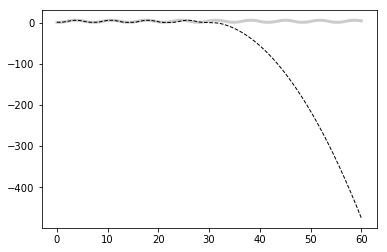

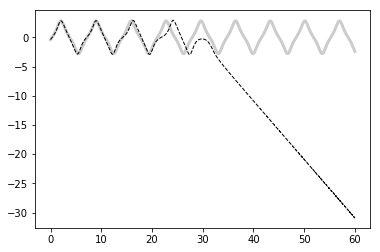

In [97]:
plt.figure()
plt.plot(t_withold,x_withold[0],c='.8',lw=3)
plt.plot(t_withold,x_recovered[0],c='0',ls='--',lw=1)
plt.show()

plt.figure()
plt.plot(t_withold,x_withold[1],c='.8',lw=3)
plt.plot(t_withold,x_recovered[1],c='0',ls='--',lw=1)
plt.show()

## Compute and Plot error in trajectory

Note that initially the error is quite good, but then it gets out of hand. 

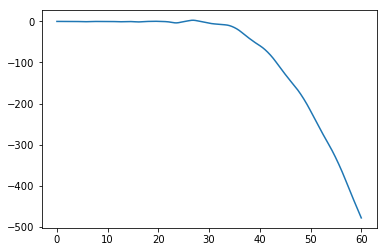

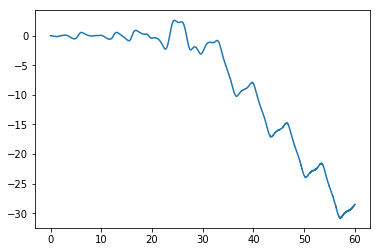

In [105]:
error_sparse_reg = x_recovered - x_withold

plt.figure()
plt.plot(t_withold,error_sparse_reg[0])
plt.show()

plt.figure()
plt.plot(t_withold,error_sparse_reg[1])
plt.show()

# 3. Time-delay embed the time series and evaluate the amount of temporal embedding required to linearize the dynamics. How many linear modes and what frequencies are required to characterize the system.

In [196]:
J=400
H = time_delay_embed(x,J)

u,s,vt = np.linalg.svd(H,full_matrices=False)

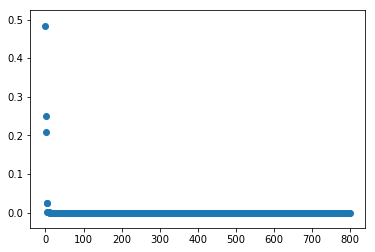

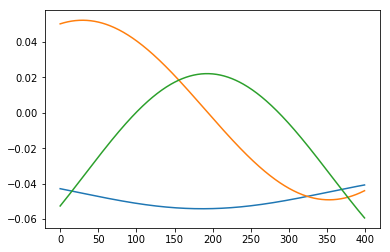

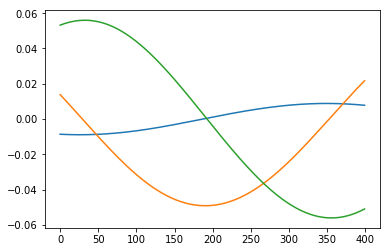

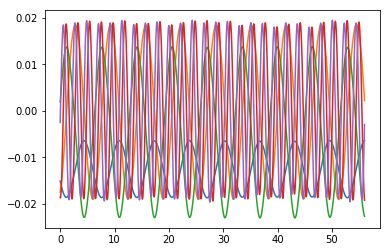

In [197]:
plt.figure()
plt.scatter(np.arange(2*J),s/np.sum(s))
plt.show()

plt.figure()
for j in range(3):
    plt.plot(np.arange(J),u[::2,j])
plt.show()

plt.figure()
for j in range(3):
    plt.plot(np.arange(J),u[1::2,j])
plt.show()

plt.figure()
for j in range(5):
    plt.plot(t[:N-J],vt[j])
plt.show()

## Find Frequencies of columns of $V$

It seems like the frqueinces come in odd multiples of the base frequency. We needed ~300 embedings to make the modes of v look sinusoidal.

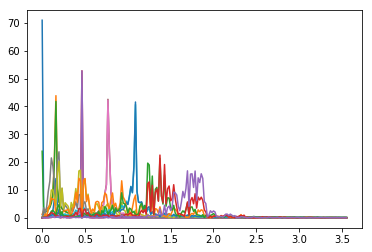

In [198]:
frequency_resolution = 1/t[N-J]

#truncate output since we have mostly low frequency components.
k=200

plt.figure()
for l in range(15):
    plt.plot(np.arange(k)*frequency_resolution,np.abs(np.fft.fft(vt[l]))[:k])
plt.show()


# 4. Use a DMD approximation on the original time series and evaluate your DMD model as a forecasting tool (use the second data set as your test set for this evaluation).

In [199]:
X1_dmd = x[:,:-J-1]
X2_dmd = x[:,1:-J]

r_dmd=2
Lambda_dmd,Phi_dmd = get_dmd_modes(X1_dmd,X2_dmd,r_dmd)

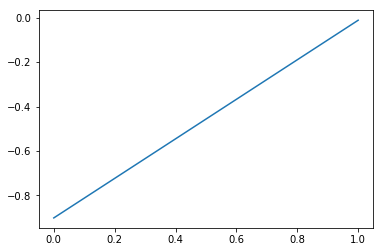

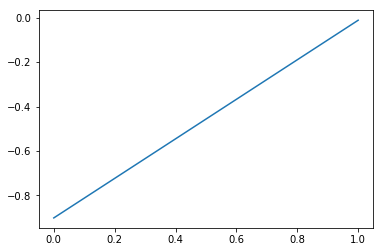

In [200]:
plt.figure()
plt.plot(np.arange(r_dmd),np.real(Phi_dmd[:,0]))
plt.show()

plt.figure()
plt.plot(np.arange(r_dmd),np.real(Phi_dmd[:,1]))
plt.show()

In [201]:
u_modes_dmd = get_mode_time_evolution(Lambda_dmd,Phi_dmd,x_withold[:,0],t)

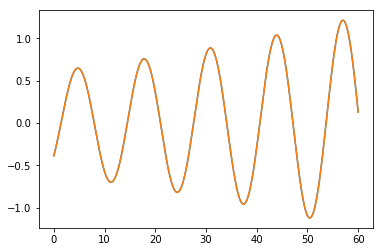

In [202]:
plt.figure()
plt.plot(t,np.real(u_modes_dmd[0]))
plt.plot(t,np.real(u_modes_dmd[1]))
plt.show()

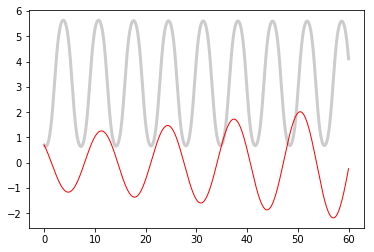

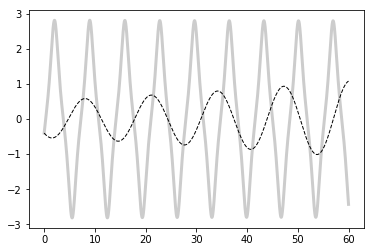

In [203]:
X_dmd = Phi_dmd@u_modes_dmd

plt.figure()
plt.plot(t_withold,x_withold[0],c='.8',linewidth=3)
plt.plot(t_withold,np.real(X_dmd[0]),c='r',ls='-',lw=1)
plt.show()

plt.figure()
plt.plot(t_withold,x_withold[1],c='.8',linewidth=3)
plt.plot(t_withold,np.real(X_dmd[1]),c='0',ls='--',lw=1)
plt.show()

Obviously the system is nonlinear, and so we do no expect DMD to work in the original coordinates. This is seen in our DMD results. We don't bother to compute the error since it is so bad.

# 5. Use the time-delay coordinates to build a Koopman/DMD model for forecasting.

Do DMD on $ X_1 $ and $ X_2 $ to find $ A $ so that $ \lVert X_2 - AX_1 \rVert_F $ is minimized where $ X_1 $ is like the time delay matrix, and $ X_2 $ is the time delay matrix forward in time one step.

In [348]:
X1 = H[:,:-1]
X2 = H[:,1:]

r=10
Lambda, Phi = get_dmd_modes(X1,X2,r)

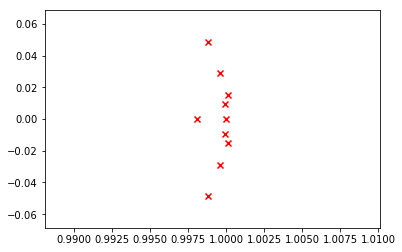

In [349]:
plt.figure()
#plt.plot(np.cos(np.linspace(0,2*np.pi,100)),np.sin(np.linspace(0,2*np.pi,100)))
plt.scatter(np.real(Lambda),np.imag(Lambda),marker='x',c='r')
#plt.axes().set_aspect('equal')
plt.show()

In [350]:
'''
for j in range(r):
    plt.figure()
    plt.plot(np.arange(2*J),np.real(Phi[:,j]),marker='.',ms='2',ls='None')
    plt.plot(np.arange(2*J),np.imag(Phi[:,j]),marker='.',ms='2',ls='None')
    plt.show()
'''

"\nfor j in range(r):\n    plt.figure()\n    plt.plot(np.arange(2*J),np.real(Phi[:,j]),marker='.',ms='2',ls='None')\n    plt.plot(np.arange(2*J),np.imag(Phi[:,j]),marker='.',ms='2',ls='None')\n    plt.show()\n"

In [351]:
u_modes = get_mode_time_evolution(Lambda,Phi,X1[:,0],t)

In [352]:
'''
for j in range(r):
    plt.figure()
    plt.plot(t,np.real(u_modes[j]))
    plt.plot(t,np.imag(u_modes[j]))
    plt.show()
'''

'\nfor j in range(r):\n    plt.figure()\n    plt.plot(t,np.real(u_modes[j]))\n    plt.plot(t,np.imag(u_modes[j]))\n    plt.show()\n'

## Plot DMD predictions on training data 

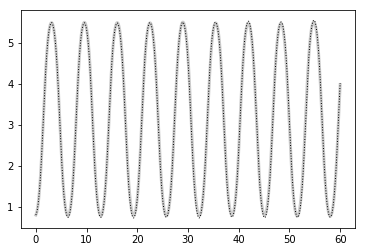

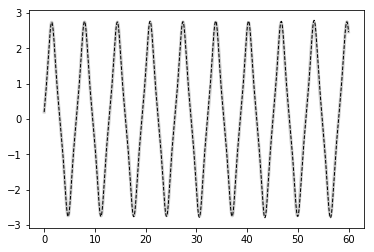

In [353]:
X_dmd_koop = Phi@u_modes

plt.figure()
plt.plot(t,x[0],c='.8',linewidth=3)
plt.plot(t,np.real(X_dmd_koop[0]),c='k',ls=':',lw=1)
plt.show()

plt.figure()
plt.plot(t,x[1],c='.8',linewidth=3)
plt.plot(t,np.real(X_dmd_koop[1]),c='0',ls='--',lw=1)
plt.show()

## Plot Error for DMD 

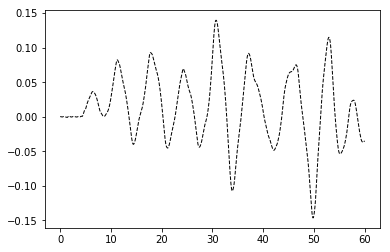

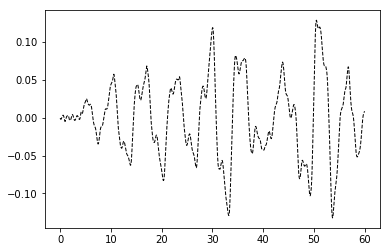

In [354]:
error = x-np.real(X_dmd_koop[:2])

plt.figure()
plt.plot(t,error[0],c='0',ls='--',lw=1)
plt.show()

plt.figure()
plt.plot(t,error[1],c='0',ls='--',lw=1)
plt.show()

## Predict on withold data
Try starting from later time (this is a bit weird because you need to regenerate the initial condition for koopman by time-delay embedding the starting data

In [355]:
x0 = time_delay_embed(x_withold[:,:J+1],J)

In [356]:
u_modes = get_mode_time_evolution(Lambda,Phi,x0[:,0],t)

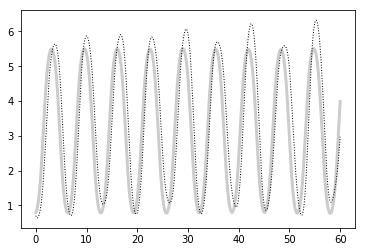

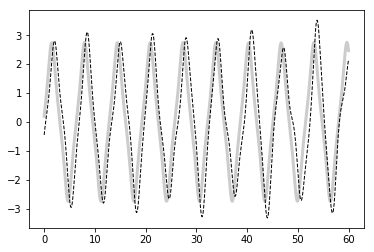

In [357]:
X_dmd_koop = Phi@u_modes

plt.figure()
plt.plot(t_withold,x[0],c='.8',linewidth=3)
plt.plot(t_withold,np.real(X_dmd_koop[0]),c='k',ls=':',lw=1)
plt.show()

plt.figure()
plt.plot(t_withold,x[1],c='.8',linewidth=3)
plt.plot(t_withold,np.real(X_dmd_koop[1]),c='0',ls='--',lw=1)
plt.show()

## Compute Error on withold data

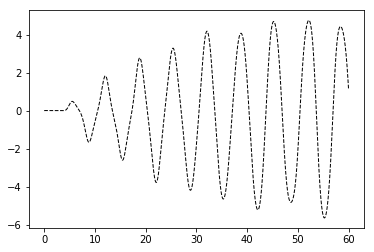

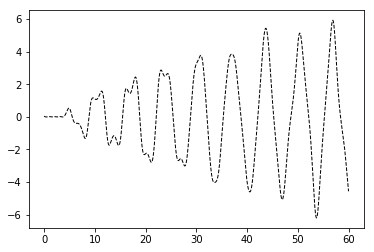

In [358]:
error = x_withold-np.real(X_dmd_koop[:2])

plt.figure()
plt.plot(t_withold,error[0],c='0',ls='--',lw=1)
plt.show()

plt.figure()
plt.plot(t_withold,error[1],c='0',ls='--',lw=1)
plt.show()

# 6. Using only the $x_1$ data column, repeat the calculations of the previous three bullets.

### 3. Time-delay embed the time series and evaluate the amount of temporal embedding required to linearize the dynamics. How many linear modes and what frequencies are required to characterize the system.

In [359]:
J_0 =400
H_0 = time_delay_embed(np.array([x[0]]),J_0) # to make shape (1,N) instead of (N,)

u_0,s_0,vt_0 = np.linalg.svd(H_0,full_matrices=False)

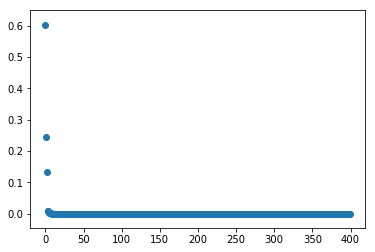

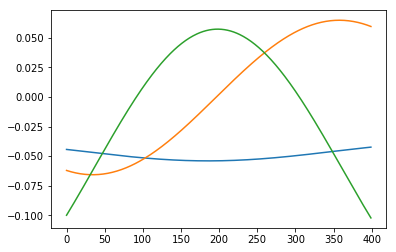

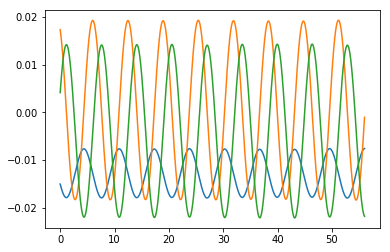

In [360]:
plt.figure()
plt.scatter(np.arange(J_0),s_0/np.sum(s_0))
plt.show()

plt.figure()
for j in range(3):
    plt.plot(np.arange(J_0),u_0[:,j])
plt.show()

plt.figure()
for j in range(3):
    plt.plot(t_withold[:-J_0],vt_0[j])
plt.show()

### 4. Use a DMD approximation on the original time series and evaluate your DMD model as a forecasting tool (use the withold data set as your test set for this evaluation).

In [361]:
X1_dmd_0 = np.array([x[0,:-J-1]])
X2_dmd_0 = np.array([x[0,1:-J]])

r_dmd_0 = 2
Lambda_dmd_0, Phi_dmd_0 = get_dmd_modes(X1_dmd_0,X2_dmd_0,r_dmd_0)

In [362]:
u_modes_dmd_0 = get_mode_time_evolution(Lambda_dmd_0,Phi_dmd_0,X1_dmd_0[:,0],t)

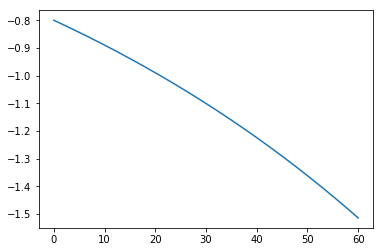

In [363]:
plt.figure()
plt.plot(t,np.real(u_modes_dmd_0[0]))
plt.show()

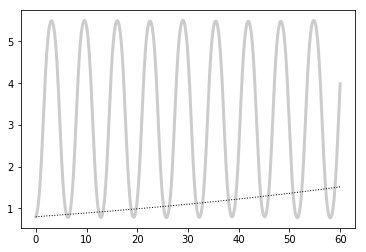

In [364]:
X_dmd_0 = Phi_dmd_0*u_modes_dmd_0

plt.figure()
plt.plot(t,x[0],c='.8',linewidth=3)
plt.plot(t,np.real(X_dmd_0[0]),c='0',ls=':',lw=1)
plt.show()

Obviously the system is nonlinear, and so we do no expect DMD to work in the original coordinates. This is seen in our DMD results. We don't bother to compute the error since it is so bad.

### 5. Use the time-delay coordinates to build a Koopman/DMD model for forecasting.

Do DMD on $ X_1 $ and $ X_2 $ to find $ A $ so that $ \lVert X_2 - AX_1 \rVert_F $ is minimized where $ X_1 $ is like the time delay matrix, and $ X_2 $ is the time delay matrix forward in time one step.

In [365]:
X1_0 = H_0[:,:-1]
X2_0 = H_0[:,1:]

r_0 = 100
Lambda_0, Phi_0 = get_dmd_modes(X1_0,X2_0,r_0)

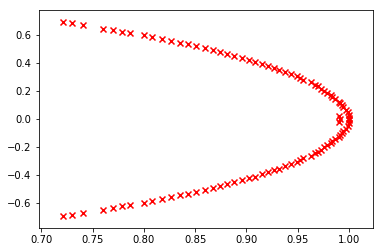

In [366]:
plt.figure()
#plt.plot(np.cos(np.linspace(0,2*np.pi,100)),np.sin(np.linspace(0,2*np.pi,100)))
plt.scatter(np.real(Lambda_0),np.imag(Lambda_0),marker='x',c='r')
#plt.axes().set_aspect('equal')
plt.show()

In [367]:
'''
for j in range(r):
    plt.figure()
    plt.plot(np.arange(J_0),np.real(Phi_0[:,j]),marker='.',ms='2',ls='None')
    plt.plot(np.arange(J_0),np.imag(Phi_0[:,j]),marker='.',ms='2',ls='None')
    plt.show()
'''

"\nfor j in range(r):\n    plt.figure()\n    plt.plot(np.arange(J_0),np.real(Phi_0[:,j]),marker='.',ms='2',ls='None')\n    plt.plot(np.arange(J_0),np.imag(Phi_0[:,j]),marker='.',ms='2',ls='None')\n    plt.show()\n"

In [368]:
u_modes_0 = get_mode_time_evolution(Lambda_0, Phi_0, X1_0[:,0],t)

In [369]:
'''
for j in range(r):
    plt.figure()
    plt.plot(t,np.real(u_modes_0[j]))
    plt.plot(t,np.imag(u_modes_0[j]))
    plt.show()
'''

'\nfor j in range(r):\n    plt.figure()\n    plt.plot(t,np.real(u_modes_0[j]))\n    plt.plot(t,np.imag(u_modes_0[j]))\n    plt.show()\n'

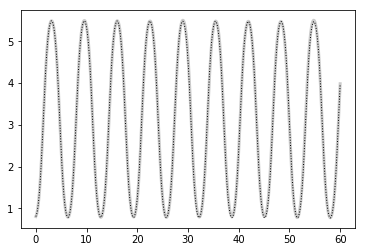

In [370]:
X_dmd_0 = Phi_0@u_modes_0

plt.figure()
plt.plot(t,x[0],c='.8',linewidth=3)
plt.plot(t,np.real(X_dmd_0[0]),c='k',ls=':',lw=1)
plt.show()


In [409]:
# take only the columns corresponding to x0 
x0 = time_delay_embed(np.array([x_withold[0,:J_0+1]]),J_0)

In [410]:
u_modes_0 = get_mode_time_evolution(Lambda_0,Phi_0,x0[:,0],t_withold)

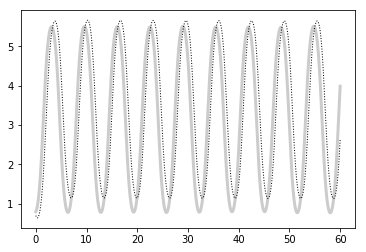

In [411]:
X_dmd_koop_0 = Phi_0@u_modes_0

plt.figure()
plt.plot(t_withold,x[0],c='.8',linewidth=3)
plt.plot(t_withold,np.real(X_dmd_koop_0[0]),c='k',ls=':',lw=1)
plt.show()

## Compute Error on withold data

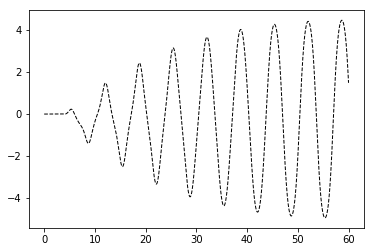

In [412]:
error = x_withold[0]-np.real(X_dmd_koop_0[:2])

plt.figure()
plt.plot(t_withold,error[0],c='0',ls='--',lw=1)
plt.show()

# 7. Now do this with only $x_2$.

### 3. Time-delay embed the time series and evaluate the amount of temporal embedding required to linearize the dynamics. How many linear modes and what frequencies are required to characterize the system.

In [415]:
J_1 =400
H_1 = time_delay_embed(np.array([x[1]]),J_1) # to make shape (1,N) instead of (N,)

u_1,s_1,vt_1 = np.linalg.svd(H_1,full_matrices=False)

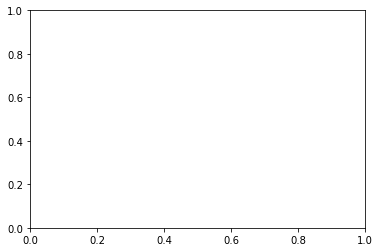

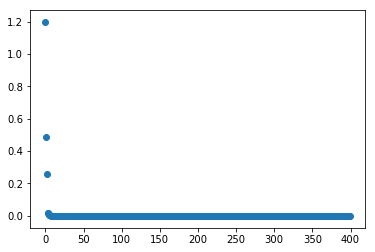

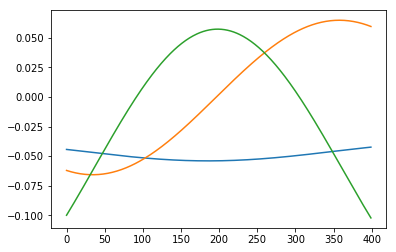

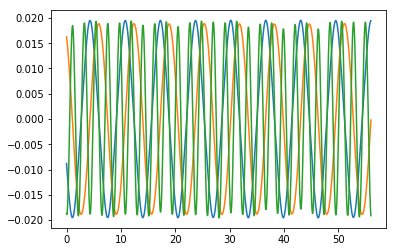

In [416]:
plt.figure()
plt.scatter(np.arange(J_1),s_0/np.sum(s_1))
plt.show()

plt.figure()
for j in range(3):
    plt.plot(np.arange(J_1),u_0[:,j])
plt.show()

plt.figure()
for j in range(3):
    plt.plot(t_withold[:-J_1],vt_1[j])
plt.show()

### 4. Use a DMD approximation on the original time series and evaluate your DMD model as a forecasting tool (use the withold data set as your test set for this evaluation).

In [419]:
X1_dmd_1 = np.array([x[1,:-J_1-1]])
X2_dmd_1 = np.array([x[1,1:-J_1]])

r_dmd_1 = 2
Lambda_dmd_1, Phi_dmd_1 = get_dmd_modes(X1_dmd_1,X2_dmd_1,r_dmd_1)

In [420]:
u_modes_dmd_1 = get_mode_time_evolution(Lambda_dmd_1,Phi_dmd_1,X1_dmd_1[:,0],t)

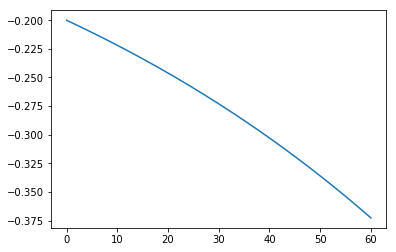

In [422]:
plt.figure()
plt.plot(t,np.real(u_modes_dmd_1[0]))
plt.show()

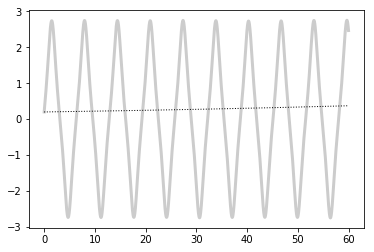

In [425]:
X_dmd_1 = Phi_dmd_1*u_modes_dmd_1

plt.figure()
plt.plot(t,x[1],c='.8',linewidth=3)
plt.plot(t,np.real(X_dmd_1[0]),c='0',ls=':',lw=1)
plt.show()

Obviously the system is nonlinear, and so we do no expect DMD to work in the original coordinates. This is seen in our DMD results. We don't bother to compute the error since it is so bad.

### 5. Use the time-delay coordinates to build a Koopman/DMD model for forecasting.

Do DMD on $ X_1 $ and $ X_2 $ to find $ A $ so that $ \lVert X_2 - AX_1 \rVert_F $ is minimized where $ X_1 $ is like the time delay matrix, and $ X_2 $ is the time delay matrix forward in time one step.

In [426]:
X1_1 = H_1[:,:-1]
X2_1 = H_1[:,1:]

r_1 = 100
Lambda_1, Phi_1 = get_dmd_modes(X1_1,X2_1,r_1)

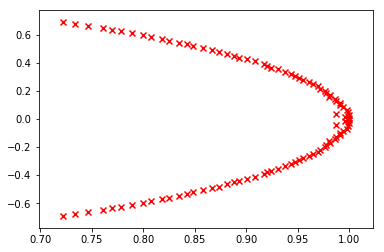

In [427]:
plt.figure()
#plt.plot(np.cos(np.linspace(0,2*np.pi,100)),np.sin(np.linspace(0,2*np.pi,100)))
plt.scatter(np.real(Lambda_1),np.imag(Lambda_1),marker='x',c='r')
#plt.axes().set_aspect('equal')
plt.show()

In [367]:
'''
for j in range(r):
    plt.figure()
    plt.plot(np.arange(J_0),np.real(Phi_0[:,j]),marker='.',ms='2',ls='None')
    plt.plot(np.arange(J_0),np.imag(Phi_0[:,j]),marker='.',ms='2',ls='None')
    plt.show()
'''

"\nfor j in range(r):\n    plt.figure()\n    plt.plot(np.arange(J_0),np.real(Phi_0[:,j]),marker='.',ms='2',ls='None')\n    plt.plot(np.arange(J_0),np.imag(Phi_0[:,j]),marker='.',ms='2',ls='None')\n    plt.show()\n"

In [428]:
u_modes_1 = get_mode_time_evolution(Lambda_1, Phi_1, X1_1[:,0],t)

In [369]:
'''
for j in range(r):
    plt.figure()
    plt.plot(t,np.real(u_modes_0[j]))
    plt.plot(t,np.imag(u_modes_0[j]))
    plt.show()
'''

'\nfor j in range(r):\n    plt.figure()\n    plt.plot(t,np.real(u_modes_0[j]))\n    plt.plot(t,np.imag(u_modes_0[j]))\n    plt.show()\n'

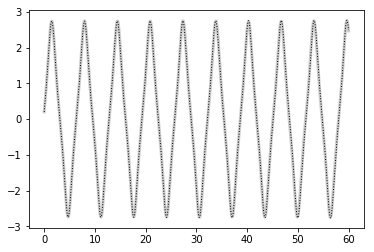

In [429]:
X_dmd_1 = Phi_1@u_modes_1

plt.figure()
plt.plot(t,x[1],c='.8',linewidth=3)
plt.plot(t,np.real(X_dmd_1[0]),c='k',ls=':',lw=1)
plt.show()


In [437]:
# take only the columns corresponding to x0 
x1 = time_delay_embed(np.array([x_withold[1,:J_0+1]]),J_1)

In [438]:
u_modes_1 = get_mode_time_evolution(Lambda_1,Phi_1,x1[:,0],t_withold)

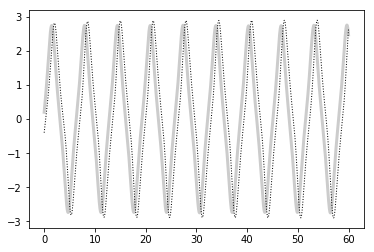

In [439]:
X_dmd_koop_1 = Phi_1@u_modes_1

plt.figure()
plt.plot(t_withold,x[1],c='.8',linewidth=3)
plt.plot(t_withold,np.real(X_dmd_koop_1[0]),c='k',ls=':',lw=1)
plt.show()

## Compute Error on withold data

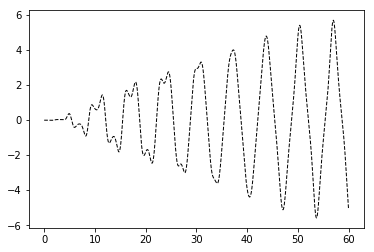

In [442]:
error = x_withold[1]-np.real(X_dmd_koop_1[:2])

plt.figure()
plt.plot(t_withold,error[1],c='0',ls='--',lw=1)
plt.show()